## IMPORT LIBRARY AND LOAD DATASET

In [ ]:
# %pip install fancyimpute
import pandas as pd
import numpy as np
from sklearn import preprocessing
from fancyimpute import KNN
import seaborn as sns
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import cohen_kappa_score, make_scorer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn import tree
from sklearn.pipeline import Pipeline

In [ ]:
# upload the data 
# from google.colab import files
# uploaded = files.upload()

train=pd.read_csv("train.csv")
test=pd.read_csv("test.csv")

In [ ]:
train.head()

,customer_id,customer_bod,gender,phone_flag,student,employment,credit_card,balance,income,tenure,default
0,8300,1993-08-17,Female,1.0,No,Self Employed,1.0,87104.12,5015120.75,4yrs 4mon,0
1,672,2007-12-17,Female,1.0,Yes,NaN,0.0,89236.34,2266076.58,4yrs 1mon,0
2,5670,2000-02-05,Female,1.0,Yes,NaN,0.0,171553.12,1779347.34,0yrs 9mon,0
3,2975,1999-11-16,Female,1.0,Yes,NaN,0.0,85979.04,2014246.24,1yrs 8mon,0
4,3883,1977-08-18,Male,1.0,No,Salaried,0.0,48874.77,5445148.31,0yrs 10mon,0


In [ ]:
#Loan ID is dropped because it is not required
train=train.drop(["customer_id"],axis=1)
test=test.drop(["customer_id"],axis=1)

## PREPROCESSING THE DATASET

In [ ]:
print(train.isnull().sum())

customer_bod      0
gender          308
phone_flag        0
student           0
employment      992
credit_card      11
balance           0
income            0
tenure            0
default           0
dtype: int64


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3693 entries, 0 to 3692
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   customer_bod  3693 non-null   object 
 1   gender        3385 non-null   object 
 2   phone_flag    3693 non-null   float64
 3   student       3693 non-null   object 
 4   employment    2701 non-null   object 
 5   credit_card   3682 non-null   float64
 6   balance       3693 non-null   float64
 7   income        3693 non-null   float64
 8   tenure        3693 non-null   object 
 9   default       3693 non-null   int64  
dtypes: float64(4), int64(1), object(5)
memory usage: 288.6+ KB


In [ ]:
# fill the missing values for categorical terms - mode
train['gender'] = train["gender"].fillna(train['gender'].mode()[0])
train['employment'] = train["employment"].fillna(train['employment'].mode()[0])
train['credit_card'] = train["credit_card"].fillna(train['credit_card'].mode()[0])

train.isnull().sum()

customer_bod    0
gender          0
phone_flag      0
student         0
employment      0
credit_card     0
balance         0
income          0
tenure          0
default         0
dtype: int64

## EXPLORATORY DATA ANALYSIS

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


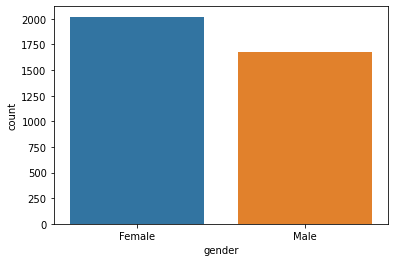

In [ ]:
# categorical attributes visualization
sns.countplot(train['gender'])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


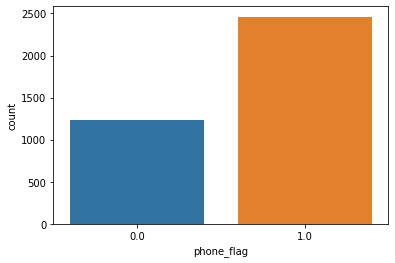

In [ ]:
sns.countplot(train['phone_flag'])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


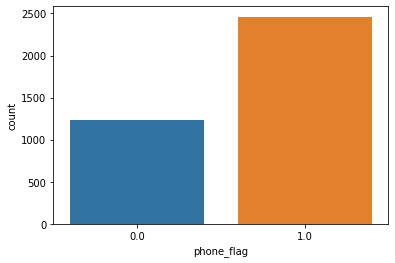

In [ ]:
sns.countplot(train['phone_flag'])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


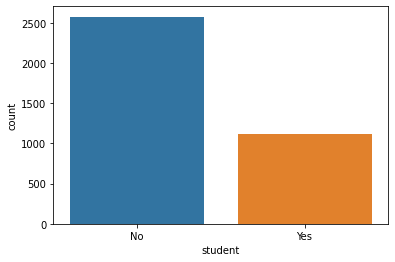

In [ ]:
sns.countplot(train['student'])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


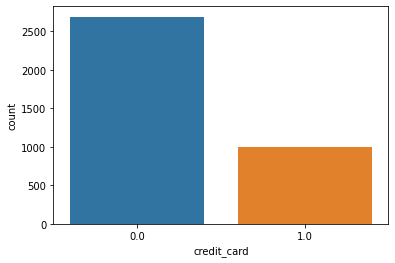

In [ ]:
sns.countplot(train['credit_card'])

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


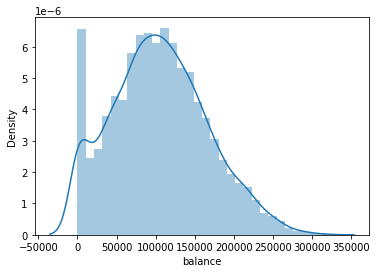

In [ ]:
sns.distplot(train["balance"])

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


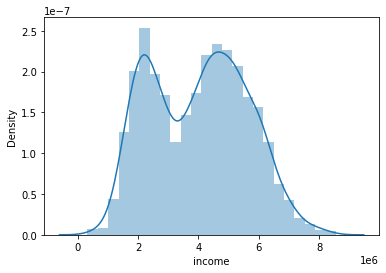

In [ ]:
sns.distplot(train["income"])

In [ ]:
train.head()

,customer_bod,gender,phone_flag,student,employment,credit_card,balance,income,tenure,default
0,1993-08-17,Female,1.0,No,Self Employed,1.0,87104.12,5015120.75,4yrs 4mon,0
1,2007-12-17,Female,1.0,Yes,Salaried,0.0,89236.34,2266076.58,4yrs 1mon,0
2,2000-02-05,Female,1.0,Yes,Salaried,0.0,171553.12,1779347.34,0yrs 9mon,0
3,1999-11-16,Female,1.0,Yes,Salaried,0.0,85979.04,2014246.24,1yrs 8mon,0
4,1977-08-18,Male,1.0,No,Salaried,0.0,48874.77,5445148.31,0yrs 10mon,0


## LOG TRANSFORMATION 

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


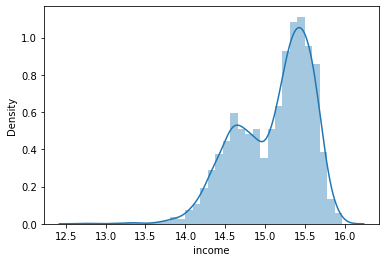

In [ ]:
train['income'] = np.log(train['income']+1)
sns.distplot(train["income"])

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


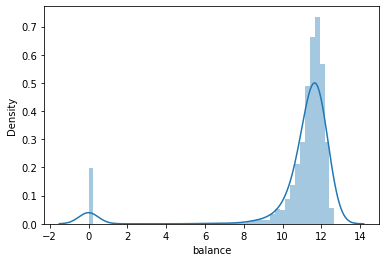

In [ ]:
train['balance'] = np.log(train['balance']+1)
sns.distplot(train["balance"])

## CORRELATION MATRIX

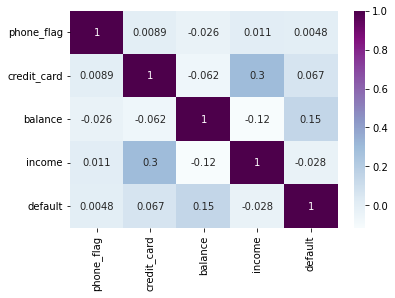

In [ ]:
import matplotlib as plt

corr = train.corr()
plt.figure.Figure(figsize=(15,10))
sns.heatmap(corr, annot = True, cmap="BuPu")

In [ ]:
from sklearn.preprocessing import LabelEncoder
cols = ['customer_bod','gender','phone_flag','student','employment','credit_card','tenure']
le = LabelEncoder()
for col in cols:
    train[col] = le.fit_transform(train[col])

In [ ]:
#Credit History and Loan Amount Term are categorical variables
train["credit_card"]=train["credit_card"].astype("object")

In [ ]:
#KNN imputation
#Assigning levels to the categories
lis = []
for i in range(0, train.shape[1]):
    if(train.iloc[:,i].dtypes == 'object'):
        train.iloc[:,i] = pd.Categorical(train.iloc[:,i])
        train.iloc[:,i] = train.iloc[:,i].cat.codes 
        train.iloc[:,i] = train.iloc[:,i].astype('object')
        lis.append(train.columns[i])

In [ ]:
#replace -1 with NA to impute
for i in range(0, train.shape[1]):
    train.iloc[:,i] = train.iloc[:,i].replace(-1, np.nan) 

In [ ]:
#Apply KNN imputation algorithm
train = pd.DataFrame(KNN(k = 3).fit_transform(train), columns = train.columns)

/usr/local/lib/python3.7/dist-packages/fancyimpute/solver.py:55: UserWarning: Input matrix is not missing any values
  warnings.warn("Input matrix is not missing any values")


Imputing row 1/3693 with 0 missing, elapsed time: 2.419
Imputing row 101/3693 with 0 missing, elapsed time: 2.420
Imputing row 201/3693 with 0 missing, elapsed time: 2.420
Imputing row 301/3693 with 0 missing, elapsed time: 2.420
Imputing row 401/3693 with 0 missing, elapsed time: 2.421
Imputing row 501/3693 with 0 missing, elapsed time: 2.422
Imputing row 601/3693 with 0 missing, elapsed time: 2.422
Imputing row 701/3693 with 0 missing, elapsed time: 2.422
Imputing row 801/3693 with 0 missing, elapsed time: 2.423
Imputing row 901/3693 with 0 missing, elapsed time: 2.423
Imputing row 1001/3693 with 0 missing, elapsed time: 2.423
Imputing row 1101/3693 with 0 missing, elapsed time: 2.424
Imputing row 1201/3693 with 0 missing, elapsed time: 2.424
Imputing row 1301/3693 with 0 missing, elapsed time: 2.424
Imputing row 1401/3693 with 0 missing, elapsed time: 2.425
Imputing row 1501/3693 with 0 missing, elapsed time: 2.425
Imputing row 1601/3693 with 0 missing, elapsed time: 2.425
Imputing 

In [ ]:
#Convert into proper datatypes
for i in lis:
    train.loc[:,i] = train.loc[:,i].round()
    train.loc[:,i] = train.loc[:,i].astype('object')

In [ ]:
train.head()

,customer_bod,gender,phone_flag,student,employment,credit_card,balance,income,tenure,default
0,1155.0,0.0,1.0,0.0,1.0,1,11.374871,15.427968,51.0,0.0
1,2752.0,0.0,1.0,1.0,0.0,0,11.399055,14.633561,48.0,0.0
2,2005.0,0.0,1.0,1.0,0.0,0,12.052654,14.391758,8.0,0.0
3,1971.0,0.0,1.0,1.0,0.0,0,11.361870,14.515756,19.0,0.0
4,153.0,1.0,1.0,0.0,0.0,0,10.797037,15.510236,1.0,0.0


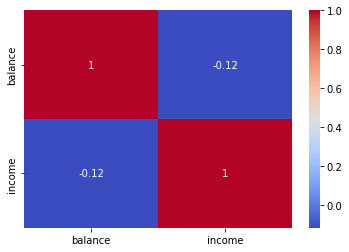

In [ ]:
#Checking correlation between continuous variable
numvar=["balance","income"]
df_corr = train.loc[:,numvar]
sns.heatmap(df_corr.corr(), annot = True, fmt='.2g',cmap= 'coolwarm')

In [ ]:
#Standardizing the numerical variables
train["balance"]= (train["balance"] - train["balance"].mean())/train["balance"].std()
train["income"]= (train["income"] - train["income"].mean())/train["income"].std()

In [ ]:
X=train.drop(["default"],axis=1)
Y=train["default"]
Y=Y.astype(int)
x=np.array(X)
y=np.array(Y)

In [ ]:
decisiontree = tree.DecisionTreeClassifier()
pipe = Pipeline(steps=[('decisiontree', decisiontree)])
criterion = ['gini', 'entropy']
max_depth = list(range(1,20))
parameters = dict(decisiontree__criterion=criterion,decisiontree__max_depth=max_depth)
dt = GridSearchCV(pipe, parameters,cv=5,scoring="f1", n_jobs=-1)
dt.fit(x,y)
scores = cross_val_score(dt, x, y,scoring="f1", cv=5)
print("DT Cross validation f1 score: {0:.2%} (+/- {1:.2%})".format(np.mean(scores), np.std(scores)*2))

DT Cross validation f1 score: 63.62% (+/- 10.81%)


In [ ]:
#Naive Bayes
parameters = {'priors':[[0.01, 0.99],[0.1, 0.9], [0.2, 0.8], [0.25, 0.75], [0.3, 0.7],[0.35, 0.65], [0.4, 0.6],[0.45,0.55],[0.5,0.5],[0.55,0.45],[0.6,0.4]]}
nb = GridSearchCV(GaussianNB(), parameters, scoring = 'f1', n_jobs=-1)
nb.fit(x, y)
scores = cross_val_score(nb, x, y,scoring = 'f1', cv=5)
print("NB Cross validation F1 score: {0:.2%} (+/- {1:.2%})".format(np.mean(scores), np.std(scores)*2))

NB Cross validation F1 score: 36.13% (+/- 4.21%)


In [ ]:
number_of_neighbors = range(1,20)
params = {'n_neighbors':number_of_neighbors}
knn = KNeighborsClassifier()
knnmodel = GridSearchCV(knn, params, cv=5,scoring="f1", n_jobs=-1)
knnmodel.fit(x,y)
scores = cross_val_score(knnmodel, x, y,scoring="f1", cv=5)
print("KNN Cross validation f1 score: {0:.2%} (+/- {1:.2%})".format(np.mean(scores), np.std(scores)*2))

KNN Cross validation f1 score: 9.23% (+/- 4.98%)


IMPLEMENT FOR THE TEST DATA

In [ ]:
test["credit_card"]=test["credit_card"].astype("object")

In [ ]:
#KNN imputation
#Assigning levels to the categories
lis = []
for i in range(0, test.shape[1]):
    if(test.iloc[:,i].dtypes == 'object'):
        test.iloc[:,i] = pd.Categorical(test.iloc[:,i])
        test.iloc[:,i] = test.iloc[:,i].cat.codes 
        test.iloc[:,i] = test.iloc[:,i].astype('object')
        lis.append(test.columns[i])

In [ ]:
#replace -1 with NA to impute
for i in range(0, test.shape[1]):
    test.iloc[:,i] = test.iloc[:,i].replace(-1, np.nan) 

In [ ]:
#Apply KNN imputation algorithm
test = pd.DataFrame(KNN(k = 3).fit_transform(test), columns = test.columns)

Imputing row 1/307 with 0 missing, elapsed time: 0.025
Imputing row 101/307 with 2 missing, elapsed time: 0.028
Imputing row 201/307 with 0 missing, elapsed time: 0.030
Imputing row 301/307 with 0 missing, elapsed time: 0.032


In [ ]:
#Convert into proper datatypes
for i in lis:
    test.loc[:,i] = test.loc[:,i].round()
    test.loc[:,i] = test.loc[:,i].astype('object')

In [ ]:
test["balance"]= (test["balance"] - test["balance"].mean())/test["balance"].std()
test["income"]= (test["income"] - test["income"].mean())/test["income"].std()

In [ ]:
x=np.array(test)

In [ ]:
#Prediction
ypred=dt.predict(x)

In [ ]:
test=pd.read_csv("test.csv")
test["default"]=ypred

In [ ]:
dict = {0 : '0', 1: '1'} 

1: Y
0: N

In [ ]:
test['default']= test['default'].map(dict) 

In [ ]:
test.columns

Index(['customer_id', 'customer_bod', 'gender', 'phone_flag', 'student',
       'employment', 'credit_card', 'balance', 'income', 'tenure', 'default'],
      dtype='object')

In [ ]:
test=test.drop(['customer_bod',	'gender',	'phone_flag',	'student',	'employment',	'credit_card',	'balance',	'income',	'tenure'],axis=1)

In [ ]:
test.head()

,customer_id,default
0,9365,0
1,999,0
2,2835,0
3,5821,0
4,2330,0


In [ ]:
from google.colab import files
a = test.to_csv('submissionfinal.csv',encoding='utf-8', index=False)

files.download('submissionfinal.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>